Задание на практику (дедлайн понедельник 20.04, 23:59) Нужно опубликовать кернел с обзором на данные в соревновании второго ДЗ. В рамках кернела попробуйте ответить на следюущие вопросы:

Распределены ли (по признакам) одинаково трейн и тест?

Есть ли аномальные, странные значения в признаках?

Есть ли выбросы в таргете?

Как (по вашему) распределен таргет в тесте? Попробуйте понять это исходя из обучающей выборки.

За каждый пункт по 3 балла, но максимум за все 10 баллов.

Дополнительная номинация: за самый интересный EDA (на наш взгляд) ставим сразу 10 баллов (даже если не ответили на все вопросы)

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import fbprophet
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns

In [2]:
train_df = pd.read_csv('/kaggle/input/hse-pml-2/train_resort.csv')
test_df = pd.read_csv('/kaggle/input/hse-pml-2/test_resort.csv')

In [3]:
train_df.rename(columns={'amount_spent_per_room_night_scaled' : 'target'}, inplace=True)

In [4]:
train_df.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,...,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,target
0,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-04-11,2015-04-16,1,1,2,0,46,3,...,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
1,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-02-01,2015-02-05,1,1,2,0,47,1,...,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
2,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-05-02,2015-06-11,2015-06-16,1,1,2,2,46,2,...,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
3,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-09-02,2015-12-14,2015-12-19,1,1,2,0,46,2,...,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346
4,cc8f05558362b7589004e57044e8b558bd228fc70da5b0...,2015-12-01,2016-01-12,2016-01-13,1,1,2,0,47,1,...,7.0,6,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,b17ef6d19c7a5b1ee83b907c595526dcb1eb06db8227d6...,8.167707


In [5]:
desc_df = pd.read_excel('/kaggle/input/hse-pml-2/column_names.xlsx')

In [6]:
desc_df

,Variable,Description
0,reservation_id,Reservation ID
1,booking_date,Date of booking
2,checkin_date,Checkin date recorded at the time of booking
3,checkout_date,Checkout date recorded at the time of booking
4,channel_code,Different channels of booking
5,main_product_code,Type of product a member has purchased
6,numberofadults,Number of adults travelling
7,numberofchildren,Number of children travelling
8,persontravellingid,Type of person travelling
9,resort_region_code,Resort Region


In [7]:
unique_ids = ['reservation_id']
dates = ['booking_date', 'checkin_date', 'checkout_date']
num_fts = ['numberofadults', 'numberofchildren', 'total_pax', 'roomnights']
cat_fts = list(set(train_df.columns) - set(['target']) - set(unique_ids) - set(dates) - set(num_fts))
# len(unique_ids) + len(dates) + len(num_fts) + len(cat_fts) + 1 == len(train_df.columns)

Посмотрим, где есть пропущенные значеня и сколько их

In [8]:
train_df.isnull().sum()[train_df.isnull().sum()>0]

season_holidayed_code     113
state_code_residence     2481
dtype: int64

In [9]:
print('В season_holidayed_code пропущено {0:.4f} % значений'.format(
    train_df.isnull().sum()['season_holidayed_code'] / train_df.shape[0]*100))
print('В state_code_residence пропущено {0:.4f} % значений'.format(
    train_df.isnull().sum()['state_code_residence'] / train_df.shape[0]*100))

В season_holidayed_code пропущено 0.0673 % значений
В state_code_residence пропущено 1.4781 % значений


In [10]:
np.sort(pd.unique(train_df.state_code_residence)) #нет номера 17

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., nan])

In [11]:
test_df.isnull().sum()[test_df.isnull().sum()>0]

season_holidayed_code       1
state_code_residence     2195
dtype: int64

В тестовой выборке также имеются пропуски в этих колонках

In [12]:
np.sort(pd.unique(test_df.state_code_residence)) #нет номера 17

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., nan])

И в тесте, и в трейне в колонке state_code_residence пропущен код 17. Заполним пропущенные значения этим кодом.

In [13]:
train_df.state_code_residence.fillna(17, inplace=True)
test_df.state_code_residence.fillna(17, inplace=True)

In [14]:
# переведем дату в другой формат

def prepare_date(df):
    df['booking_date'] = pd.to_datetime(df['booking_date'])
    df['checkin_date'] = pd.to_datetime(df['checkin_date'])
    df['checkout_date'] = pd.to_datetime(df['checkout_date'])
    
prepare_date(train_df)
prepare_date(test_df)

# EDA

Посмотрим на распределение таргета на трейне

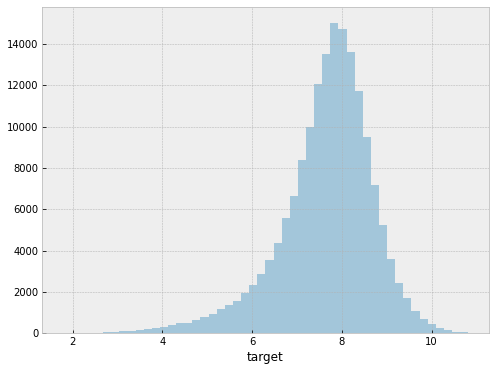

In [15]:
plt.figure(figsize=(8,6))
plt.style.use('bmh')
_ = sns.distplot(train_df.target, kde=False)

Видно, что значений меньше 4 и больше 10 не так много, присутсвуют экстримальные значения

In [16]:
pd.unique(train_df.season_holidayed_code), pd.unique(test_df.season_holidayed_code) 

(array([ 2.,  3.,  4.,  1., nan]), array([ 2.,  1.,  3.,  4., nan]))

Разберемся что показывает признак season_holidayed_code и посмотрим на пропуски. Судя по значениям признакака, он соответсвует каждому сезону, но cезонов всего 4. Неизвестно какому из сезонов могут соответсвовать пропуски, заполним их цифрой 5 

In [17]:
train_df.season_holidayed_code.fillna(5, inplace=True)

In [18]:
def sh_code_analysis(date_col, df, codes, is_train=False):
    for code in codes:
        plt.figure(figsize = (16, 8))
        plot = sns.countplot(x= date_col , data = df[df.season_holidayed_code == code])
        unique_date_count = df[df.season_holidayed_code == code][date_col].nunique()
        freq = unique_date_count//80
        if freq ==0:
            freq = 1
        plot.set_xticklabels(labels= [x.get_text()[:10] for x in plot.get_xticklabels()][::freq], 
                         rotation = 90, fontsize=10)
        _ = plot.set(xticks = range(0,len(plot.get_xticklabels()),freq))
        plt.title('Code = {}'.format(code), fontsize = 14)
        plt.xlabel(date_col, fontsize = 12)
        plt.ylabel('count', fontsize = 12)
    
    plt.figure(figsize = (8,6))
    sns.countplot(x = 'season_holidayed_code', data = df)
    
    
    
    if is_train == True:
        
        for c in codes:
            plt.figure(figsize = (8,6))
            sns.distplot(df[df.season_holidayed_code == c]['target'], kde=False, label=str(c))
            plt.legend()
    
        plt.figure(figsize = (8,6))
        sns.boxplot(x = df.season_holidayed_code, y = df.target)
    
    

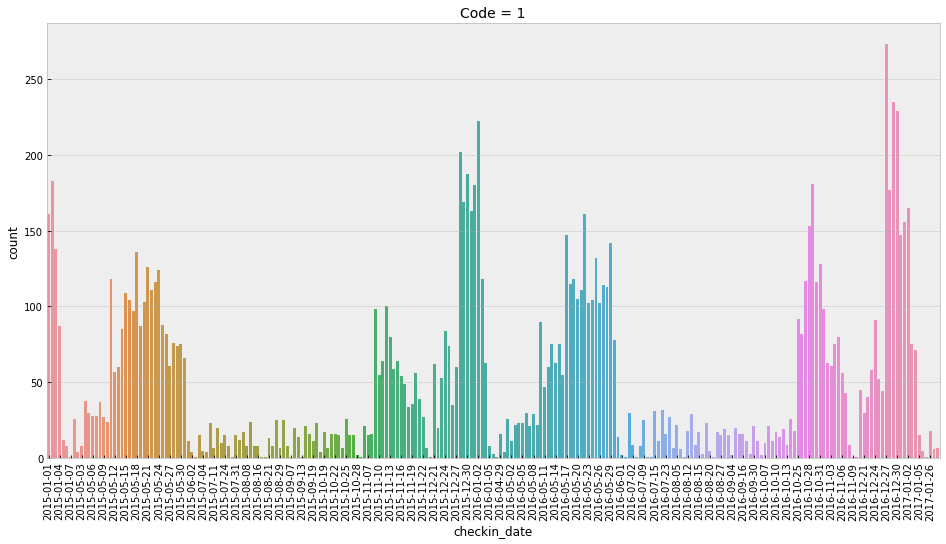

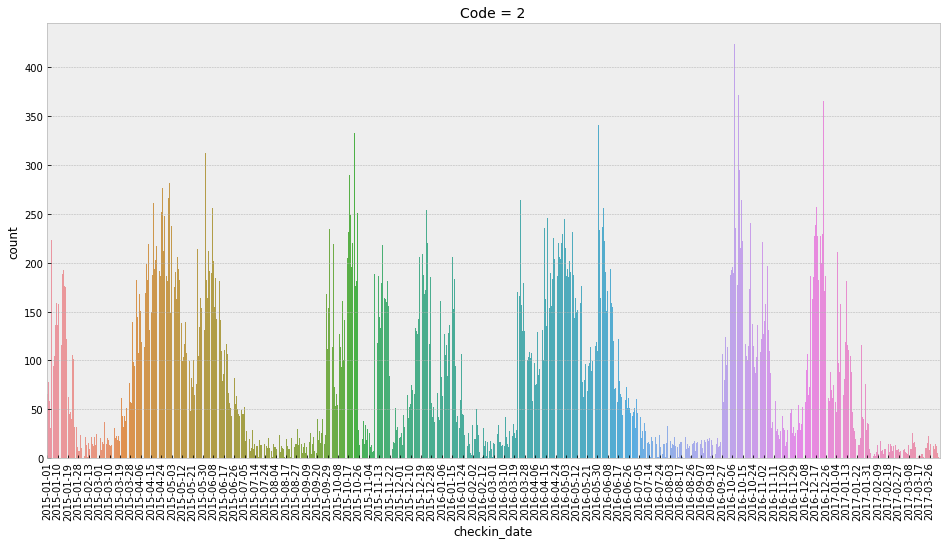

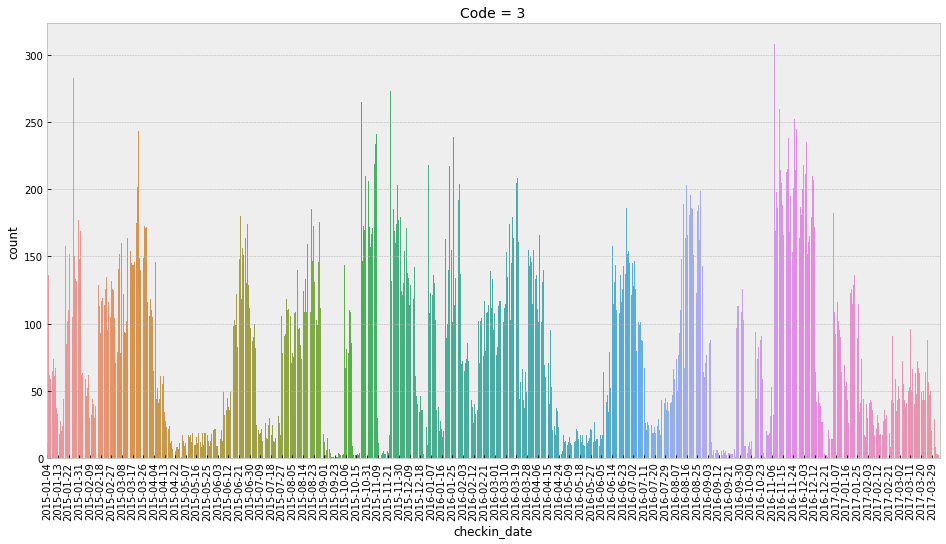

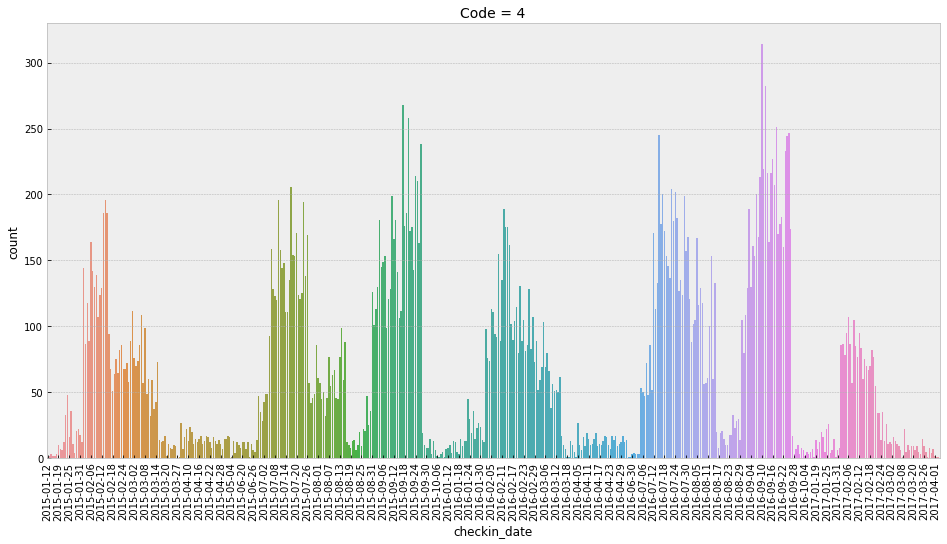

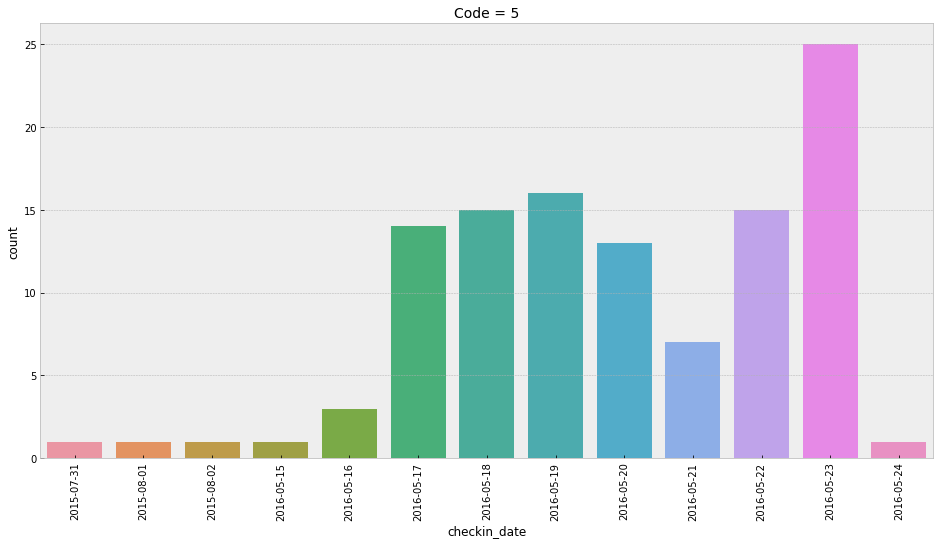

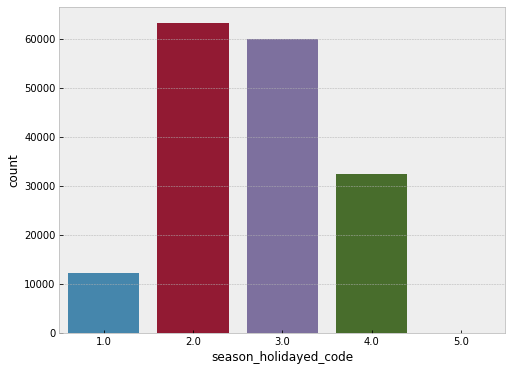

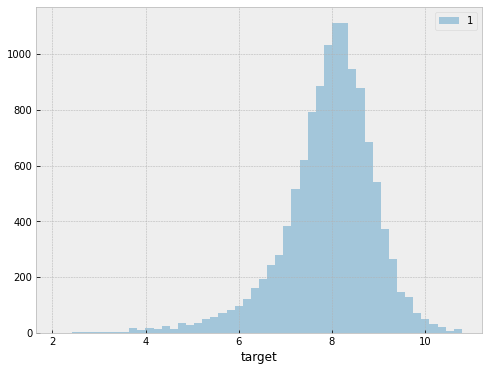

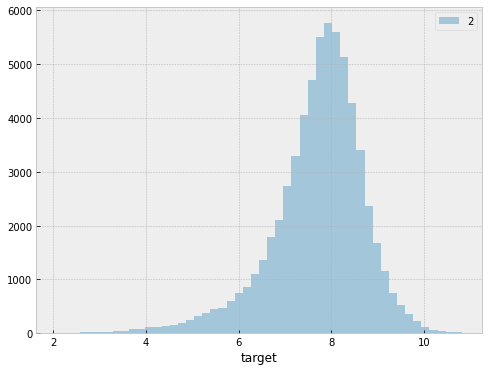

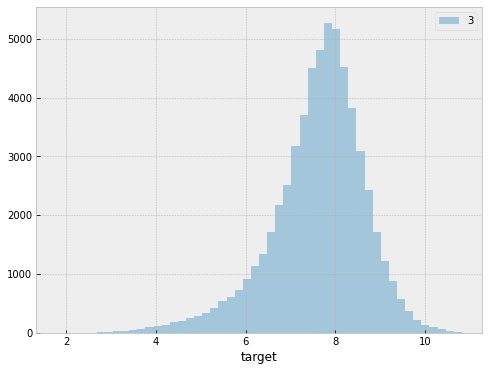

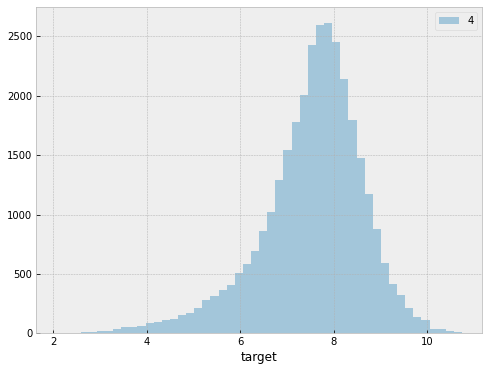

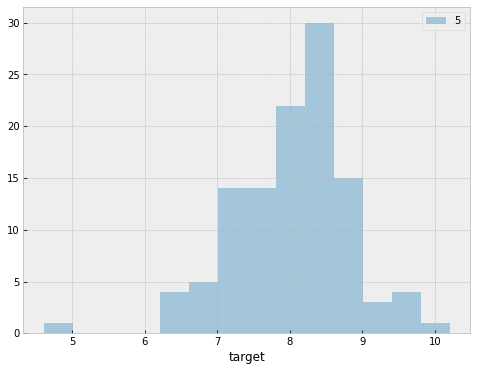

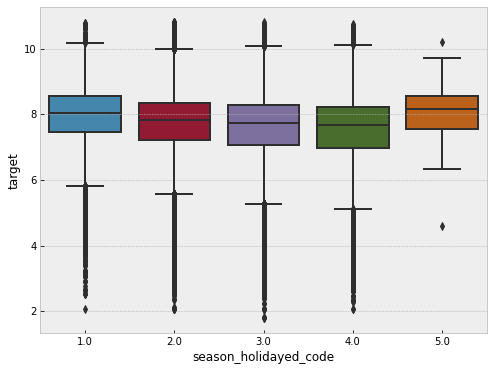

In [19]:
sh_code_analysis('checkin_date', train_df, [1,2,3,4,5], is_train=True)

In [20]:
test_df.season_holidayed_code.fillna(5, inplace=True)

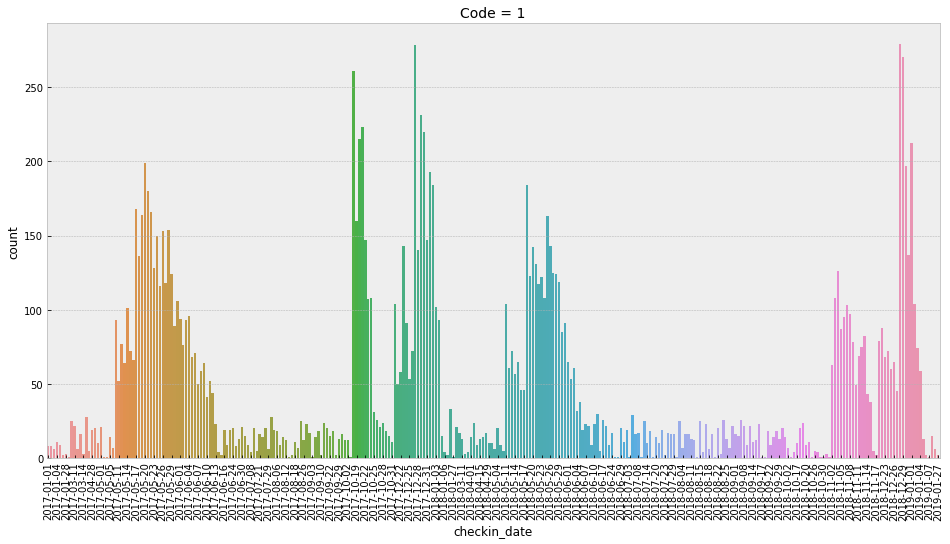

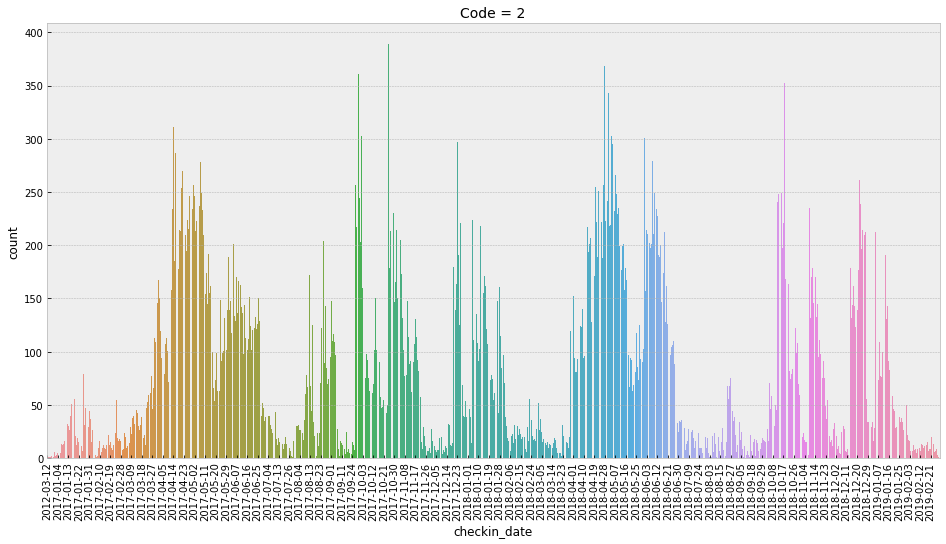

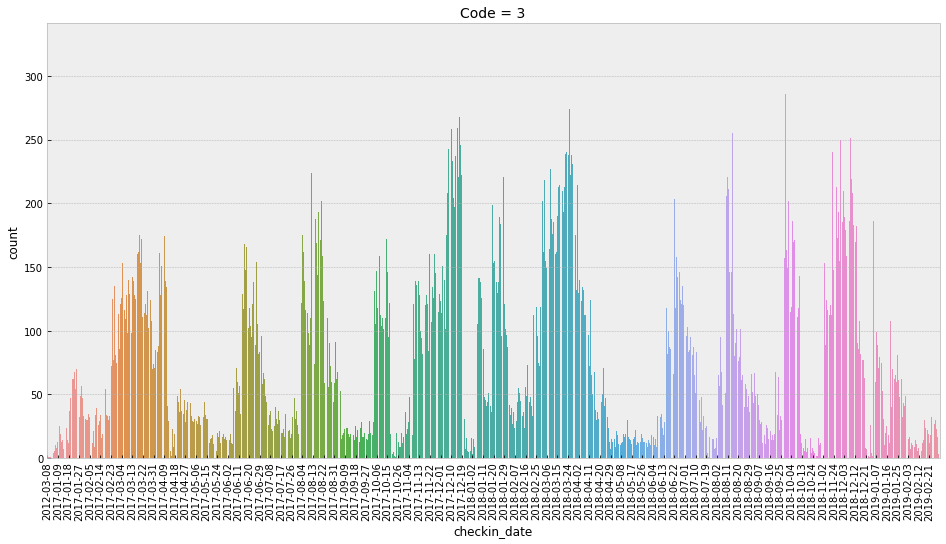

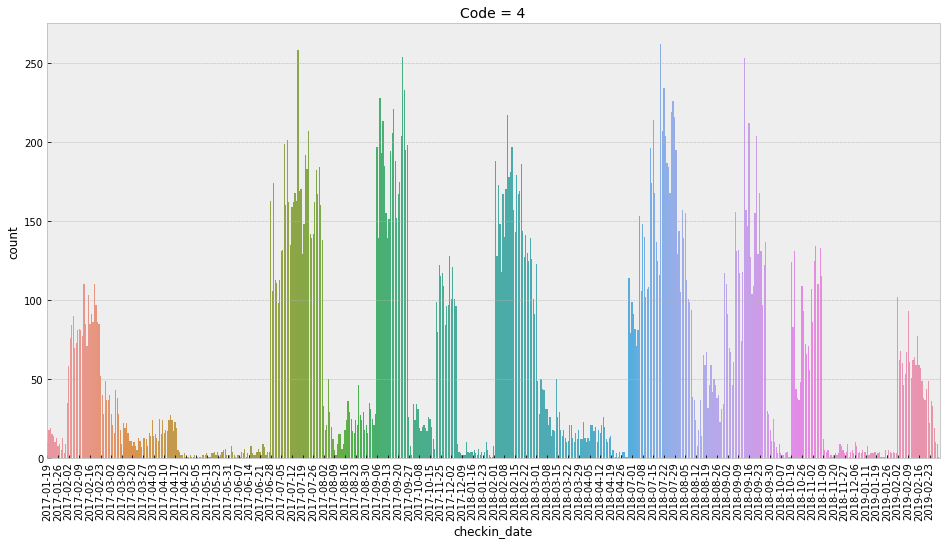

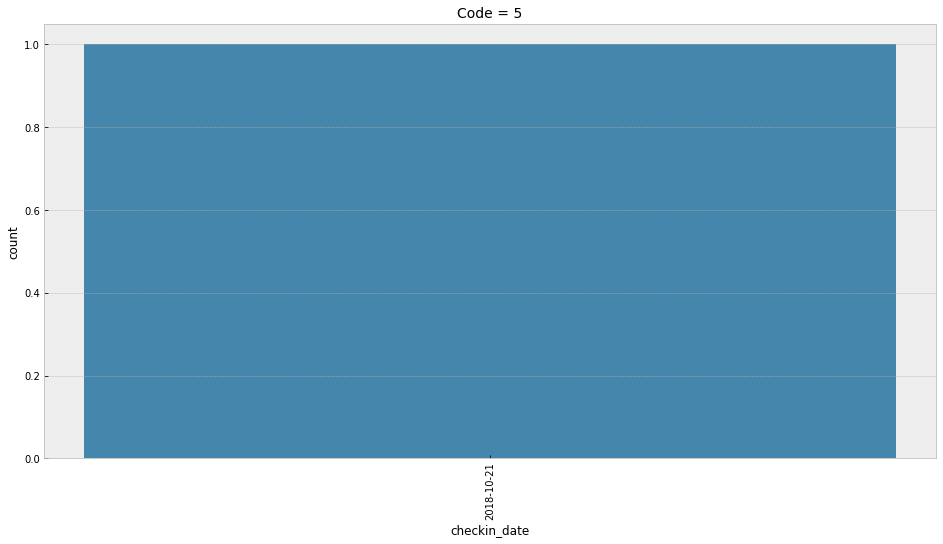

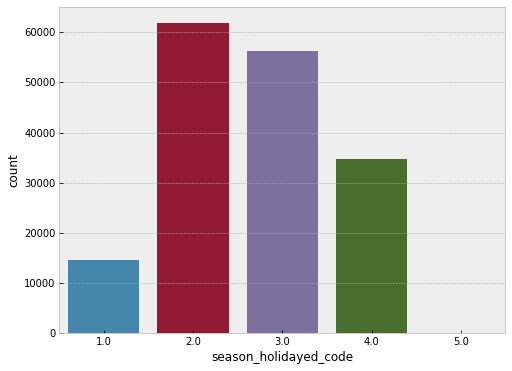

In [21]:
sh_code_analysis('checkin_date', test_df, [1,2,3,4,5])

Ожидал увидеть, что каждое значение кода будет в определенных месяцах каждого года, но этого я не увидел. Также распределение таргета в зависимости от разных значений season_holidayed_code ведет себя примерно одинаково, единсственное, что стоить отметить это то, что при чем меньше номер кода, тем больше медиана у таргета, за исключением кода, который добавили ранее(5). 

При анализе в каких месяцах появляются одни и те же значения кода на трейне и на тесте, кажется видно, что трейн и тест собраны на разных временных периодах. Нужно проверить это

In [22]:
train_df.checkin_date.min(), train_df.checkin_date.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2017-04-04 00:00:00'))

In [23]:
test_df.checkin_date.min(), test_df.checkin_date.max()

(Timestamp('2012-03-08 00:00:00'), Timestamp('2019-03-01 00:00:00'))

Посмотрим на booking_date

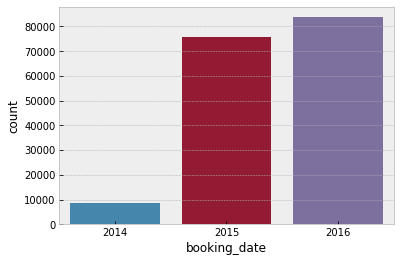

In [24]:
_ = sns.countplot(x = train_df.booking_date.apply(lambda x : x.year))

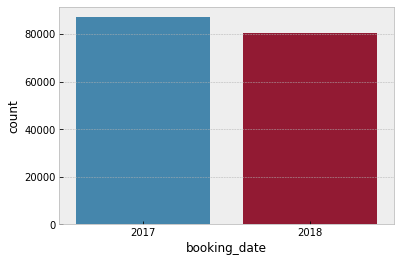

In [25]:
_ = sns.countplot(x = test_df.booking_date.apply(lambda x : x.year))

Так и оказалось: на трейне данные о поездках, забронированных до 2017 года, а на тесте - после 2017. Но есть немного странного, на тесте есть объекты с checkin_date меньше 2017 года т.е. бронировали на дату из прошлого

In [26]:
# сколько поездок забронированы на даты из прошлого
(test_df.checkin_date < test_df.booking_date).sum(), (test_df.checkout_date < test_df.booking_date).sum()

(12, 12)

In [27]:
np.all(test_df[test_df.checkin_date < test_df.booking_date].index == test_df[
    test_df.checkout_date < test_df.booking_date].index)
print('Наблюдения с бронированием в прошлое {}'.format(test_df[test_df.checkin_date 
                                                              < test_df.booking_date].index.values))

Наблюдения с бронированием в прошлое [ 6 14 28 37 39 60 61 67 68 78 80 85]


In [28]:
(train_df.checkin_date < train_df.booking_date).sum(), (train_df.checkout_date < train_df.booking_date).sum()

(0, 0)

На трейне таких случаев нет. Перейдем к другим признакам

In [29]:
((train_df.numberofadults + train_df.numberofchildren == train_df.total_pax).sum()/train_df.shape[0],
(test_df.numberofadults + test_df.numberofchildren == test_df.total_pax).sum()/test_df.shape[0])

(0.433163140680016, 0.4119012248453282)

В большинстве случаях на трейне и на тесте сумма взрослых и детей не равна общему числу людей. Посмотрим поближе на эти признаки. Также посмотрим еще на один вещественный признак roomnights

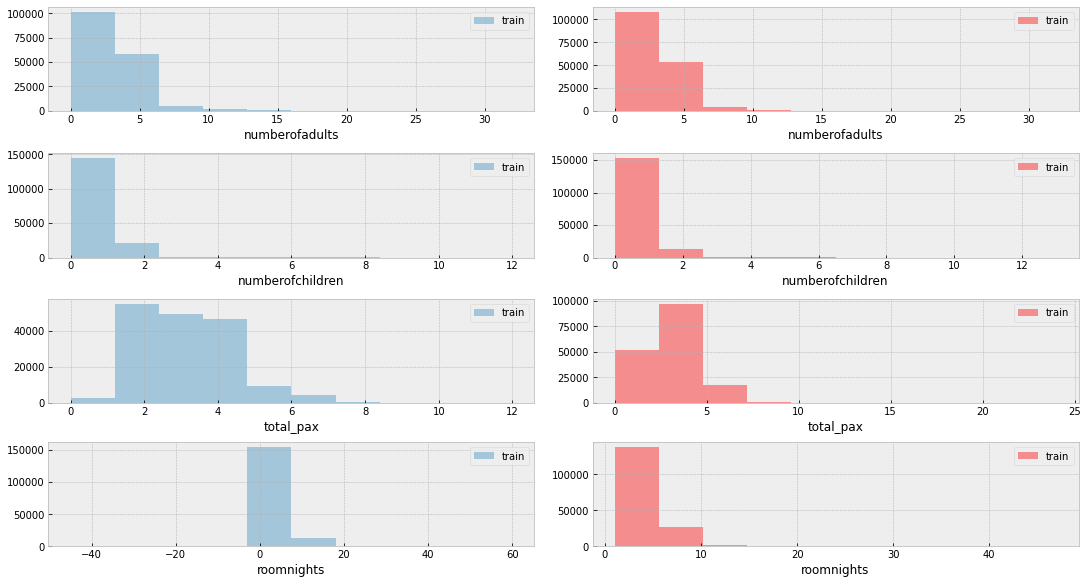

In [30]:
fig, axs = plt.subplots(len(num_fts), 2, constrained_layout=True, figsize = (15, 8))
for i, ft in enumerate(num_fts):
    sns.distplot(train_df[ft], kde=False, label = 'train', bins = 10, ax=axs[i][0])
    axs[i][0].legend()
    sns.distplot(test_df[ft], kde=False, label = 'train', bins = 10, ax=axs[i][1], color = 'r')
    axs[i][1].legend()
    

Если смотреть на итоговое число туристов, то распределения на трейне и тесте различаются. Однако для числа детей и взрослых по отдельности распределения похожи.

Посмотрим на гистограммы roomnights поближе.

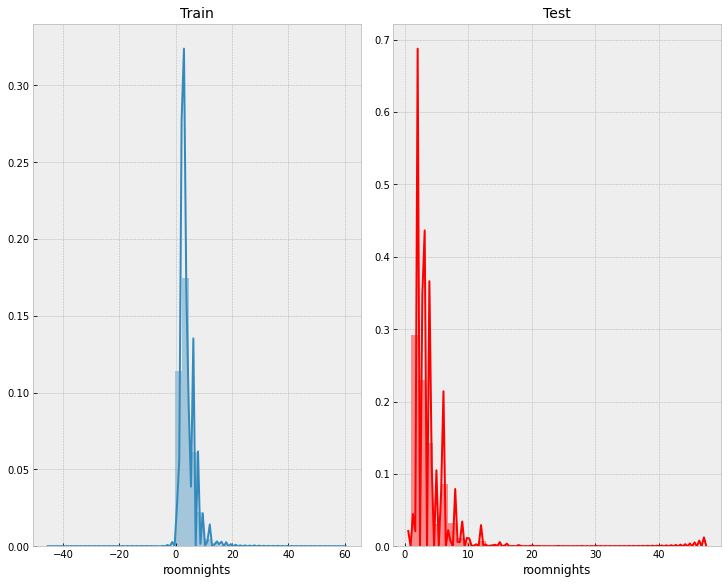

In [31]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize = (10, 8))
sns.distplot(train_df.roomnights, kde=True, label = 'train', ax=axs[0], bins = train_df.roomnights.nunique())
axs[0].set_title('Train', fontsize = 14)
sns.distplot(test_df.roomnights, kde=True, label='test', ax=axs[1], bins=test_df.roomnights.nunique(), color='red')
_ = axs[1].set_title('Test', fontsize = 14)

In [32]:
train_df.roomnights.min(), train_df.roomnights.max()

(-45, 60)

In [33]:
train_df.roomnights.value_counts().sort_index()

-45        1
 0         1
 1      9607
 2     40593
 3     47489
 4     29389
 5      6148
 6     19354
 7      1498
 8      5553
 9      2772
 10     1594
 11      158
 12     1952
 13       76
 14      282
 15      467
 16      328
 17       29
 18      180
 19       10
 20      111
 21       60
 22        7
 23       10
 24       50
 25        5
 26        8
 27       24
 28       28
 29        4
 30       29
 31        7
 32        5
 33        2
 34        2
 35        2
 36       12
 39        1
 60        1
Name: roomnights, dtype: int64

In [34]:
test_df.roomnights.min(), test_df.roomnights.max()

(1, 47)

На трейне есть наблюдения с отрицательным и нулевым значениями roomnights, что странно.

Перейдем к категориальным фичам

In [35]:
train_df[cat_fts].dtypes

state_code_residence        float64
booking_type_code             int64
channel_code                  int64
reservationstatusid_code     object
state_code_resort             int64
room_type_booked_code         int64
memberid                     object
member_age_buckets           object
persontravellingid            int64
main_product_code             int64
resort_region_code            int64
cluster_code                 object
season_holidayed_code       float64
resort_id                    object
resort_type_code              int64
dtype: object

In [36]:
# на тесте больше значений memberid, чем на трейне
train_df.memberid.nunique(), test_df.memberid.nunique()

(74513, 78300)

In [37]:
def te_isin_tr(col):
    return np.all(np.isin(pd.unique(test_df[col]), pd.unique(train_df[col])))

У memberid очень много значений, следовательно порисовать что-то на графиках будет проблематично, поэтому пока забудем про этот признак. Еще стоит отметить, что на тесте значений этого признака больше, чем на трейне

In [38]:
eda_cat_fts = list(set(cat_fts) - set(['memberid']))

In [39]:
#какие вообще значения принимают категориальные признаки
for i in eda_cat_fts:
    print(i, pd.unique(train_df[i]))

state_code_residence [ 7.  8.  2.  6.  3.  1.  5.  9.  4. 17. 25. 15. 12. 10. 28. 24. 23. 20.
 14. 11. 13. 21. 18. 16. 26. 27. 22. 19. 31. 34. 32. 30. 33. 29. 37. 35.
 36. 38.]
booking_type_code [1 2]
channel_code [1 3 2]
reservationstatusid_code ['A' 'B' 'C']
state_code_resort [ 5  1  2  6  9 10  4  3  7 11 13]
room_type_booked_code [4 3 2 1 5 6]
member_age_buckets ['F' 'H' 'D' 'E' 'I' 'G' 'C' 'B' 'A' 'J']
main_product_code [1 2 3 4 7]
resort_region_code [3 1 2]
cluster_code ['F' 'E' 'D' 'B' 'A' 'C']
season_holidayed_code [2. 3. 4. 1. 5.]
persontravellingid [  46   47   45 4752 4753]
resort_id ['39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac8f9e9a2596173f80c9'
 '535fa30d7e25dd8a49f1536779734ec8286108d115da5045d77f3b4185d8f790'
 'd4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f90da3a666eec13ab35'
 'b17ef6d19c7a5b1ee83b907c595526dcb1eb06db8227d650d5dda0a9f4ce8cd9'
 'ff5a1ae012afa5d4c889c50ad427aaf545d31a4fac04ffc1c4d03d403ba4250a'
 '0b918943df0962bc7a1824c0555a389347b4febdc7cf9d1254406d80

In [40]:
for ft in eda_cat_fts:
    print(ft, 'ok?   ', te_isin_tr(ft), ', type:', train_df.dtypes[ft])

state_code_residence ok?    True , type: float64
booking_type_code ok?    True , type: int64
channel_code ok?    True , type: int64
reservationstatusid_code ok?    False , type: object
state_code_resort ok?    True , type: int64
room_type_booked_code ok?    True , type: int64
member_age_buckets ok?    True , type: object
main_product_code ok?    True , type: int64
resort_region_code ok?    True , type: int64
cluster_code ok?    True , type: object
season_holidayed_code ok?    True , type: float64
persontravellingid ok?    False , type: int64
resort_id ok?    False , type: object
resort_type_code ok?    True , type: int64


In [41]:
train_df.state_code_residence = train_df.state_code_residence.astype(int)
test_df.state_code_residence = test_df.state_code_residence.astype(int)

train_df.season_holidayed_code = train_df.season_holidayed_code.astype(int)
test_df.season_holidayed_code = test_df.season_holidayed_code.astype(int)

Видно, что для некоторых признаков появляются новые значения на тестовой выборке.

In [42]:
from sklearn.preprocessing import LabelEncoder

def eda_le(le_fts, cat_fts):
    eda_cat_fts = cat_fts.copy()
    for ft in le_fts:
        le = LabelEncoder()
        train_df['edaLE_' + ft] = le.fit_transform(train_df[ft])
        test_df['edaLE_' + ft] = le.transform(test_df[ft])
        eda_cat_fts.remove(ft)
        eda_cat_fts.append('edaLE_' + ft)
    
    return eda_cat_fts

eda_cat_fts = eda_le(['member_age_buckets', 'cluster_code'], cat_fts=eda_cat_fts)
# eda_cat_fts.remove('reservationstatusid_code')
eda_cat_fts.remove('resort_id')

In [43]:
def EDAcat(fts):
    fig, axs = plt.subplots(len(fts), 3, constrained_layout=True, figsize = (18, 5*len(fts)))
    for i, ft in enumerate(fts):
        n_unique = train_df[ft].nunique()
        sns.countplot(train_df[ft], ax=axs[i][0])
        axs[i][0].title.set_text('Train')
        axs[i][0].set_xticklabels(labels= [l for l in axs[i][0].get_xticklabels()], 
                                  fontsize=[10 if n_unique<=10 else 8][0])
        if n_unique <=10:
            sns.boxplot(x=train_df[ft], y=train_df.target, ax = axs[i][1])
            axs[i][1].title.set_text('Train')
        else:
            sns.scatterplot(x=train_df[ft], y=train_df.target, ax=axs[i][1])
            axs[i][1].title.set_text('Train')
        sns.countplot(test_df[ft], ax=axs[i][2])
        axs[i][2].set_xticklabels(labels= [l for l in axs[i][2].get_xticklabels()], 
                                  fontsize=[10 if n_unique<=10 else 8][0])
        axs[i][2].title.set_text('Test')    

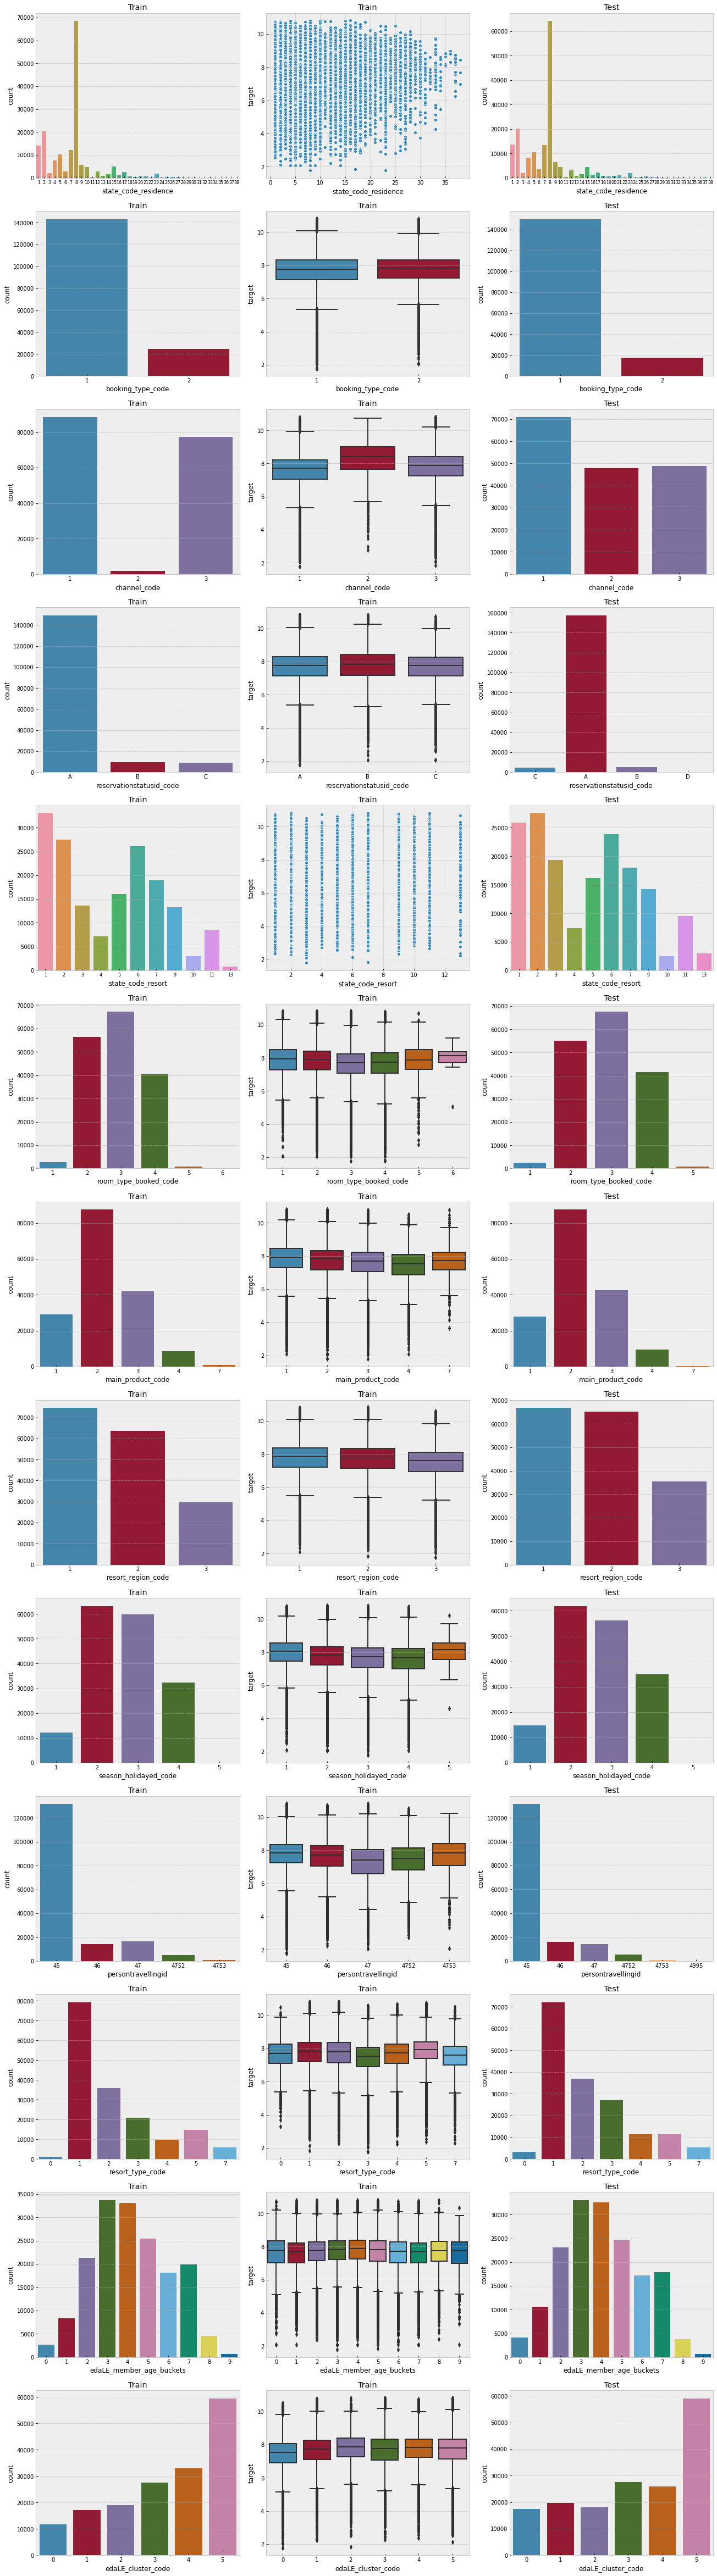

In [44]:
EDAcat(eda_cat_fts)

Из этих графиков видно, что для исследуемых признаков распределние на тесте и на трейне примерно одинаково, исключением является channel_code, у которого на трейне мало наблюдений со значением 2, также странно себя ведет reservationstatusid_code. Также у некоторых признаков появляются новые значения на тесте. Еще можно отметить несколько особенностей. Например, что практически для каждого из значений state_code_residence таргет принимает всевозможные значения, также это видно для state_code_resort, возможно они как-то связаны; а значение признака booking_type_code не влияет на таргет.

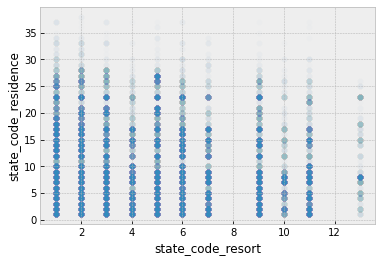

In [45]:
_ = sns.scatterplot(y = train_df.state_code_residence, x = train_df.state_code_resort, alpha=0.01)

Кажется, что чем больше state_code_resort, тем меньше поездок туда совершается. Возможно это как-то связано с удаленностью региона

Посмторим теперь на айдишники

In [46]:
train_df[['memberid', 'reservation_id', 'resort_id']].head()

,memberid,reservation_id,resort_id
0,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,03930f033646d073462b35d411616323597715ac4fc398...,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...
1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,535fa30d7e25dd8a49f1536779734ec8286108d115da50...
2,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...
3,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...
4,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,cc8f05558362b7589004e57044e8b558bd228fc70da5b0...,b17ef6d19c7a5b1ee83b907c595526dcb1eb06db8227d6...


На первый взгляд в них есть что-то общее

In [47]:
x = set(train_df.reservation_id).intersection(train_df.memberid)
print(x)
x = set(train_df.reservation_id).intersection(train_df.resort_id)
print(x)
x = set(train_df.memberid).intersection(train_df.resort_id)
print(x)

set()
set()
set()


Посмотрим на пересечения трейна с тестом

In [48]:
def tr8te (fts):
    num_of_intersec = []
    train_share = []
    test_share = []
    index = []
    
    for ft in fts:
        train_set = set(train_df[ft])
        test_set = set(test_df[ft])
        intersec_set = train_set.intersection(test_set)
        
        num_of_intersec.append(len(intersec_set))
        train_share.append(len(intersec_set)/len(train_set))
        test_share.append(len(intersec_set)/len(test_set))
        index.append(ft)
        
    df = pd.DataFrame({'IntersectionNumber' : num_of_intersec, 'TrainShare': train_share, 
                       'TestShare': test_share}, index=index)
    return df
        

In [49]:
tr8te(['memberid', 'reservation_id', 'resort_id'])

,IntersectionNumber,TrainShare,TestShare
memberid,52024,0.698187,0.664419
reservation_id,0,0.000000,0.000000
resort_id,31,1.000000,0.968750


memberid пересекается больше всех, reservation_id не имеет пересечений, а у resort_id появляются новые значения на тесте. Посмотрим теперь на даты.

In [50]:
def make_date_fts(dates, df):
    for date in dates:
        df['weekday_' + date] = df[date].apply(lambda x: x.day_name())
        df['month_' + date] = df[date].apply(lambda x: x.month_name())
        df['quarter_' + date] = df[date].apply(lambda x: x.quarter)
        df['year_' + date] = df[date].apply(lambda x: x.year)


make_date_fts(dates, train_df)
make_date_fts(dates, test_df)

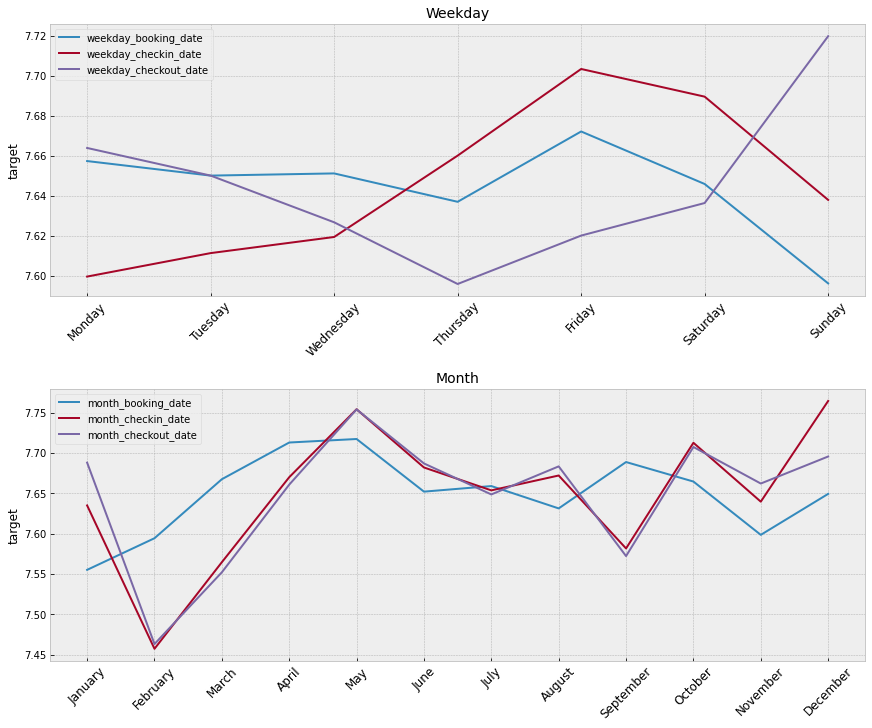

In [51]:
def plot_dates():
    weekday_fts=[]
    month_fts = []
    quarter_fts = []
    year_fts = []
    
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
   
    
    for col in train_df.columns:
        if 'weekday_' in col:
            weekday_fts.append(col)
        elif 'month_' in col:
            month_fts.append(col)
        elif 'quarter_' in col:
            quarter_fts.append(col)
        elif 'year_' in col:
            year_fts.append(col)

    fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize = (12, 10))
    for ft in weekday_fts:
        mean_df = train_df.groupby([ft])['target'].mean()
        mean_df = mean_df.reindex(weekdays)
        mean_df = mean_df.reset_index()
        sns.lineplot(x=ft, y='target', data=mean_df, sort=False, label=ft, ax=axs[0])
    axs[0].set_xticklabels(weekdays, fontsize=12, rotation=45)
    axs[0].set_title('Weekday', fontsize=14)
    axs[0].set_xlabel('')
    axs[0].set_ylabel('target',fontsize=12)
    
    for ft in month_fts:
        mean_df = train_df.groupby([ft])['target'].mean()
        mean_df = mean_df.reindex(months)
        mean_df = mean_df.reset_index()
        sns.lineplot(x=ft, y='target', data=mean_df, sort=False, label=ft, ax=axs[1])
    axs[1].set_xticklabels(months, fontsize=12, rotation=45)
    axs[1].set_title('Month', fontsize=14)
    axs[1].set_xlabel('')
    axs[1].set_ylabel('target',fontsize=12)
    
    
    
plot_dates()

По данным графикам можо оценить активность путешественников. Например, видно, что с января по май наблюдается рост поездок. 

### Вывод

Про странные и аномальные значения признаков, выбросы в таргете и распределения признаков на трейне и тесте было подробно сказано по ходу анализа. Кратко подведем итог:

1. Распределены ли (по признакам) одинаково трейн и тест?

Для большинства признаков это выполняется.

2. Есть ли аномальные, странные значения в признаках?

Да, есть.

3. Есть ли выбросы в таргете?

Да, есть.

4. Как (по вашему) распределен таргет в тесте? Попробуйте понять это исходя из обучающей выборки.

Что касается таргета в тесте, я думаю он распределен примерно также, как и на трейне.